# Nonadiabatic dynamics based on exact factorization in Libra


## Table of Content: <a name="TOC"></a>

1. [Generic setups](#1)

2. [Theoretical Background](#2)

3. [Model Hamiltonians](#3)

4. [Choosing the Nonadiabatic Dynamics Methodology](#4)

5. [Choosing initial conditions: Nuclear and Electronic](#5)

6. [Running the calculations](#6)

7. [Plotting the results](#7)

8. [Comparison with quantum dynamics](#8)


## 1. Generic setups
<a name="1"></a>[Back to TOC](#TOC)

Here, we import all necessary libraries, set up some definitions (e.g. colors), and define the function that would be calling model Hamiltonians also defined within Libra package.

Packages that set dynamic parameters are imported from the recipes directory. Their names specify their corresponding nonadiabatic dynamics methods. Specifically, nonadiabatic dynamics methods based on exact factorization (XF) contain 'xf' in their names. Try to run other methods for comparison.

    from recipes import shxf
    from recipes import ehrenfest_adi_ld, ehrenfest_dia, mfsd
    from recipes import fssh, sdm, bcsh

In [17]:
import sys
import cmath
import math
import os
import h5py
import matplotlib.pyplot as plt   # plots
import numpy as np
import time
import warnings

from liblibra_core import *
import util.libutil as comn
from libra_py import units
import libra_py.models.Holstein as Holstein
import libra_py.models.Tully as Tully
import libra_py.models.Subotnik as Subotnik
import libra_py.models.Esch_Levine as Esch_Levine
from libra_py import dynamics_plotting
import libra_py.dynamics.tsh.compute as tsh_dynamics
import libra_py.dynamics.tsh.plot as tsh_dynamics_plot
import libra_py.data_savers as data_savers

from recipes import shxf
from recipes import ehrenfest_adi_ld, ehrenfest_dia, mfsd
from recipes import fssh, sdm, bcsh

import libra_py.dynamics.exact.compute as dvr
import libra_py.dynamics.exact.save as dvr_save

#from matplotlib.mlab import griddata
#%matplotlib inline 
warnings.filterwarnings('ignore')

colors = {}
colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   
colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      
colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  
colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]

## 2. Theoretical Background
<a name="2"></a>[Back to TOC](#TOC)

Add later 
Mixed quantum-classical equations..
Coupled trajectories/Independent trajectories

Table for each method

### 2.1 Decoherence-Induced Surface Hopping based on XF (DISH-XF) or SHXF

### 2.2 Mixed Quantum-Classical based on XF (MQCXF)


## 3. Model Hamiltonians
<a name="3"></a>[Back to TOC](#TOC)

First, let's define the `compute_model` function that returns all the necessary objects and properties for the dynamics. 

In [18]:
def compute_model(q, params, full_id):

    model = params["model"]
    res = None
    
    if model==1:        
        res = Holstein.Holstein2(q, params, full_id) 
    elif model==2:
        res = Tully.Tully3(q, params, full_id)
    elif model==3:
        res = Subotnik.double_arch_geometry(q, params, full_id)
    elif model==4:
        res = Esch_Levine.JCP_2020(q, params, full_id)
    else:
        pass            

    return res

Here, we define several sets of parameters:

* Sets 1 to 4 - for the 2-level Holstein Hamiltonians. These are just parabolas with constant coupling.
* Sets 5 - for the ECWR (Extended Coupling With Reflection) Tully model
* Sets 6 - for the DAG (Double Arch Geometry) or symmetrized ECWR Tully model
* Sets 7 to 10 - for the n-level Esch-Levine Hamiltonians. These are just lines or bundles of lines crossing with yet another line and having a constant coupling. These models are for 2- to 5-state problems. 

In [19]:
model_params1 = {"model":1, "model0":1, "nstates":2, "E_n":[0.0,  0.0], "x_n":[0.0,  2.5],"k_n":[0.002, 0.005],"V":0.000}
model_params2 = {"model":1, "model0":1, "nstates":2, "E_n":[0.0,  0.0], "x_n":[0.0,  2.5],"k_n":[0.002, 0.005],"V":0.001}
model_params3 = {"model":1, "model0":1, "nstates":2, "E_n":[0.0,  0.0], "x_n":[0.0,  2.5],"k_n":[0.002, 0.005],"V":0.01}
model_params4 = {"model":1, "model0":1, "nstates":2, "E_n":[0.0, -0.01], "x_n":[0.0,  0.5],"k_n":[0.002, 0.008],"V":0.001}

model_params5 = {"model":2, "model0":2, "nstates":2} # ECR
model_params6 = {"model":3, "model0":3, "nstates":2} # DAG

model_params7 = {"model":4, "model0":4, "nstates":2, 
                 "w0":0.015, "w1":0.005, "V":0.005, "eps":0.0, "i_crit":2, "delta":0.01 } # Esch-Levine

model_params8 = {"model":4, "model0":4, "nstates":3, 
                 "w0":0.015, "w1":0.005, "V":0.005, "eps":0.0, "i_crit":3, "delta":0.01 } # Esch-Levine

model_params9 = {"model":4, "model0":4, "nstates":5, 
                 "w0":0.015, "w1":0.005, "V":0.005, "eps":0.0, "i_crit":4, "delta":0.01 } # Esch-Levine

model_params10 = {"model":4, "model0":4, "nstates":5, 
                 "w0":0.015, "w1":0.005, "V":0.005, "eps":0.02, "i_crit":3, "delta":0.01 } # Esch-Levine

all_model_params = [model_params1, model_params2, model_params3, model_params4, 
                    model_params5, model_params6, 
                    model_params7, model_params8, model_params9, model_params10
                   ]

Choose the model to simulate here by setting `model_indx`.

In [20]:
# 0 - Holstein, trivial crossing, 2 level
# 1 - Holstein, strong nonadiabatic, 2 level
# 2 - Holstein, adiabatic, 2 level
# 3 - Holstein, double crossing, strong nonadiabatic, 2 level
# 4 - Tully, extended crossing with reflection, 2 level
# 5 - Double arch geometry or symmetrized ECWR, 2 level
# 6 - Esch-Levine, LZ-like, 2 level
# 7 - Esch-Levine, 1 crosses 2 parallel, 3 level
# 8 - Esch-Levine, 1 crosses 4 evenly-spaced parallel, 5 level
# 9 - Esch-Levine, 1 crosses 4 parallel split into 2 groups, 5 level

#################################
# Give the model used an index
model_indx = 5
################################

model_params = all_model_params[model_indx]

Here, visualization of each model system is done. Change parameters accordingly.

In [21]:
# New plotting:
# Common setups
plot_params = {"figsize":[24, 6], "titlesize":24, "labelsize":28, "fontsize": 28, "xticksize":26, "yticksize":26,
               "colors": colors, "clrs_index": clrs_index,
               "prefix":F"case", "save_figures":0, "do_show":1,
               "plotting_option":1, "nac_idof":0 }


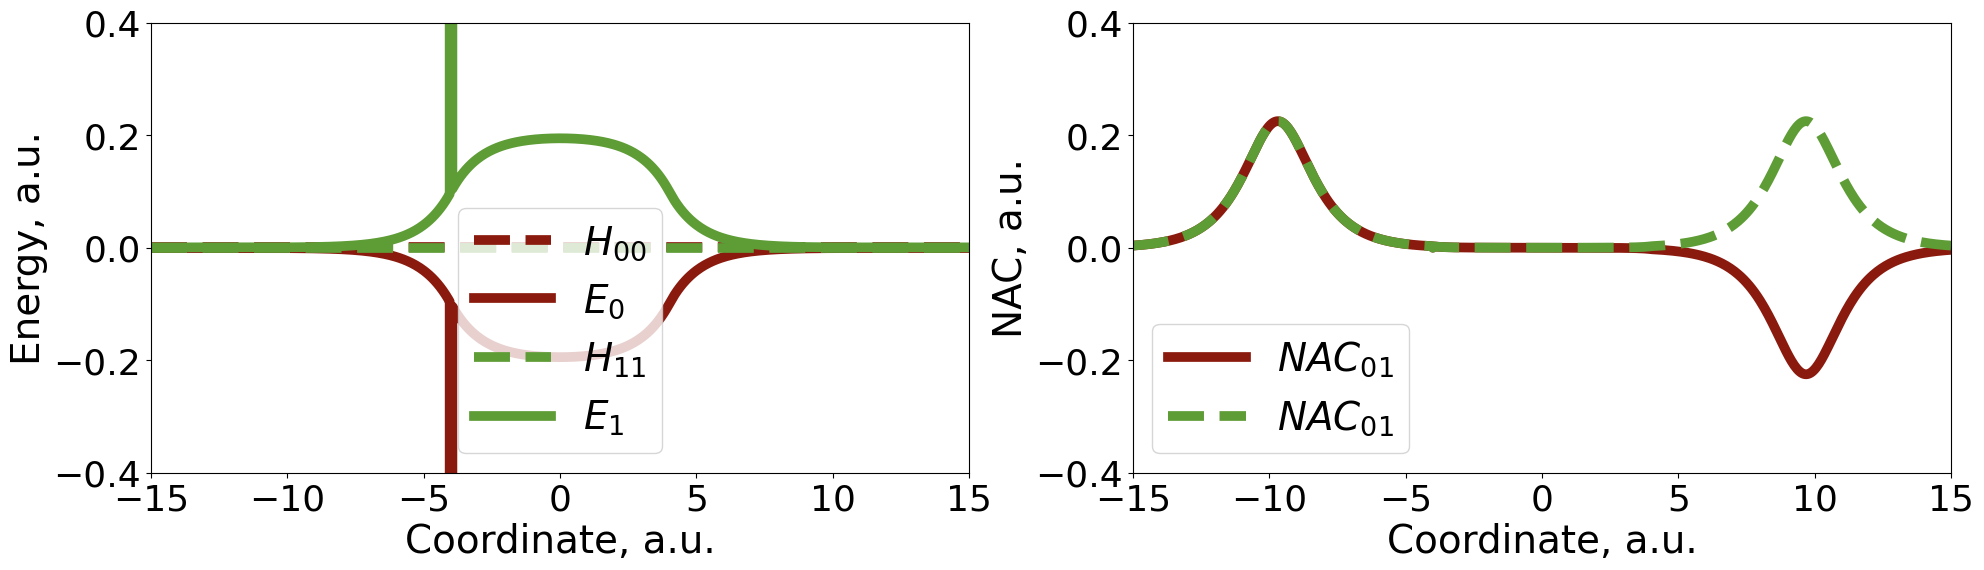

In [7]:
list_states = [x for x in range(model_params["nstates"])]

# Holstein
#plot_params.update( { "xlim":[-1, 5], "ylim":[-0.01, 0.03], "ylim2":[-2, 2], "show_nac_abs":1 })
#dynamics_plotting.plot_surfaces(compute_model, [ model_params ], list_states, -4.0, 5.0, 0.05, plot_params)

# Tully
plot_params.update( { "xlim":[-15.0, 15.0], "ylim":[-0.4, 0.4], "ylim2":[-0.4, 0.4], "show_nac_abs":1 })
dynamics_plotting.plot_surfaces(compute_model, [ model_params ], list_states, -15.0, 15.0, 0.05, plot_params)

# Esch-Levine
#plot_params.update( { "xlim":[-4, 8], "ylim":[-0.06, 0.06], "ylim2":[-3, 3], "show_nac_abs":1 })
#dynamics_plotting.plot_surfaces(compute_model, [ model_params ], list_states, -4.0, 8.0, 0.05, plot_params)

## 4. Choosing the Nonadiabatic Dynamics Methodology 
<a name="4"></a>[Back to TOC](#TOC)

In this section, we go over parameters to set up a computational methodology. 

Let's start with the simulation-specific parameters:

* `nsteps` -  how many steps of dynamics to compute
* `nstaj` - how many trajectories to use
* `nstates:2` - all our models are 2-level systems
* `dt:1` - nuclear integration timestep in a.u. of time
* `num_electronic_substeps` - do multiple steps of electronic integration per nuclear step
* `isNBRA` and `is_nbra` - is set to `1`, will turn on some simplifications and optimization for NBRA type of calculations. Here, we are doing the non-NBRA case
* `frogress_frequency:0.1` - printing out a message evry `2500 x 0.1 = 250` steps
* `which_adi_states` - properties of which adiabatic states to save, we only have 2
* `which_dia_states` - properties of which diabatic states to save, we only have 2
* `mem_output_level:4` - how much data to save into the hdf5 output files. This is the most intensive output, usually needed only for some special cases (extra-analysis, debugging, new methods, demonstration like htis, etc.)
* `properties_to_save` - list of properties to be computed on the fly and saved into hdf5 output file.

In [8]:
# For setting nsteps
list_nsteps = []
for i in range(len(all_model_params)):
    if all_model_params[i]["model"] == 1: #Holstein
        list_nsteps.append(25000)
    elif all_model_params[i]["model"] == 2: #ECR
        list_nsteps.append(4000)
    elif all_model_params[i]["model"] == 3: #DAG
        list_nsteps.append(3000)
    elif all_model_params[i]["model"] == 4: #Esch-Levine
        list_nsteps.append(25000)

In [9]:
NSTATES = model_params["nstates"]

dyn_general = { "nsteps":list_nsteps[model_indx], "ntraj":25, "nstates":NSTATES,
                "dt":1.0, "num_electronic_substeps":1, "isNBRA":0, "is_nbra":0,
                "progress_frequency":0.1, "which_adi_states":range(NSTATES), "which_dia_states":range(NSTATES),      
                "mem_output_level":3,
                "properties_to_save":[ "timestep", "time", "q", "p", "f", "Cadi", "Cdia", "Epot_ave", "Ekin_ave", "Etot_ave",
                "se_pop_adi", "se_pop_dia", "sh_pop_adi"],
                "prefix":"adiabatic_md", "prefix2":"adiabatic_md"
              }

#[ "timestep", "time", "q", "p", "f", "Cadi", "Cdia", "Epot_ave", "Ekin_ave", "Etot_ave",
#                "se_pop_adi", "se_pop_dia", "sh_pop_adi", "hvib_adi", "hvib_dia", "St", "basis_transform", "D_adi" ]

Now, it is time to select the type of calculations we want to do. Keep in mind that some options are related to each other, so usually one would need to correlate the choices. For methods based on surface hopping, default options are used for frustrated hops and how to rescale momenta on hops.

In [10]:
#################################
# Give the recipe above an index
method_indx = 7
#################################

if method_indx == 0:
    ehrenfest_dia.load(dyn_general)  # Ehrenfest, dia
elif method_indx == 1:
    ehrenfest_adi_nac.load(dyn_general)  # Ehrenfest, adi with NACs    
elif method_indx == 2:
    ehrenfest_adi_ld.load(dyn_general)  # Ehrenfest, adi with LD
elif method_indx == 3:
    mfsd.load(dyn_general)  # MFSD
    
elif method_indx == 4:
    fssh.load(dyn_general)  # FSSH
elif method_indx == 5:
    sdm.load(dyn_general)  # SDM with default EDC parameters
elif method_indx == 6:
    bcsh.load(dyn_general)  # BCSH 

elif method_indx == 7:
    shxf.load(dyn_general)  # SHXF 

## 5. Choosing initial conditions: Nuclear and Electronic
<a name="5"></a>[Back to TOC](#TOC)

The setup of the parameters below is rather intuitive:

* `ndof` - number of nuclear degrees of freedom
* `q` - nuclear coordinates, should be of length `ndof`
* `p` - nuclear momenta, should be of length `ndof`
* `mass` - nuclear masses, should be of length `ndof`
* `force_constant` - should be of length `ndof`; this is the force constant of the harmonic potential that defines the width of the Gaussian wavepacket (that is the ground-state solution for such potential)
* `init_type` - how to sample (or not) momenta and coordinates

For electronic variables:
* `ndia` - the number of diabatic states
* `nadi` - the number of adiabatic states
* `rep` - representation in which we initialize the electronic variables:
  - 0 - diabatic wfc;
  - 1 - adiabatic wfc;
  - 2 - diabatic density matrix;
  - 3 - adiabatic density matrix;
* `istates` - the populations of all `rep` states, should be of length `nadi`
* `init_type` - how to sample amplitudes

In [11]:
#*********************** This is for the initial condition type **************************
#============== How nuclear DOFs are initialized =================
#icond_nucl = 0  # Coords and momenta are set exactly to the given value
#icond_nucl = 1  # Coords are set, momenta are sampled
#icond_nucl = 2  # Coords are sampled, momenta are set
icond_nucl = 3  # Both coords and momenta are sampled

nucl_params = { "ndof":1, "q":[-4.0], "p":[0.0], 
                "mass":[2000.0], "force_constant":[0.01], 
                "init_type":icond_nucl }

#============= How electronic DOFs are initialized ==================
#icond_elec = 2  # amplitudes all have the same phase
icond_elec = 3  # amplitudes gain random phase 

#============= Also select the representation ========================
# rep = 0 # diabatic wfc
rep = 1 # adiabatic wfc

istates = []
for i in range(NSTATES):
    istates.append(0.0)    
    
elec_params = {"verbosity":2, "init_dm_type":0,
               "ndia":NSTATES, "nadi":NSTATES, 
               "rep":rep, "init_type":icond_elec, "istates":istates
              }

#******************** This is for specific values in initial conditions *******************
#####################################
# Select a specific initial condition
icond_indx = 0
#####################################    

if model_indx in [0, 1]: # Holstein model
    if icond_indx==0:
        nucl_params["q"] = [-4.0]
        elec_params["istates"][1] = 1.0          
    elif icond_indx==1:
        nucl_params["q"] = [-1.0]
        elec_params["istates"][0] = 1.0 
elif model_indx in [2]: # Holstein model
    if icond_indx==0:
        nucl_params["q"] = [-4.0]
        elec_params["istates"][1] = 1.0          
    elif icond_indx==1:
        nucl_params["q"] = [-2.0]
        elec_params["istates"][0] = 1.0 
elif model_indx in [3]: # Holstein model
    if icond_indx==0:
        nucl_params["q"] = [-4.0]
        elec_params["istates"][1] = 1.0
    elif icond_indx==1:
        nucl_params["q"] = [-3.0]
        elec_params["istates"][0] = 1.0
elif model_indx in [4]: # Tully, ECR
    if icond_indx==0:
        nucl_params["q"] = [-15.0]
        nucl_params["p"] = [25.0]
        elec_params["istates"][0] = 1.0
elif model_indx in [5]: # Tully, DAG
    if icond_indx==0:
        nucl_params["q"] = [-20.0]
        nucl_params["p"] = [20.0]
        elec_params["istates"][0] = 1.0
elif model_indx in [6]: # Esch-Levine 2-level
    if icond_indx==0:
        nucl_params["q"] = [-3.0]
        elec_params["istates"][1] = 1.0
elif model_indx in [7]: # Esch-Levine 3-level
    if icond_indx==0:
        nucl_params["q"] = [-3.0]
        elec_params["istates"][2] = 1.0
elif model_indx in [8,9]: # Esch-Levine 5-level, two types
    if icond_indx==0:
        nucl_params["q"] = [-3.0]
        elec_params["istates"][4] = 1.0

## 6. Running the calculations
<a name="6"></a>[Back to TOC](#TOC)

In [23]:
%%time

dyn_params = dict(dyn_general)
dyn_params.update({ "prefix":F"model{model_indx}-method{method_indx}-icond{icond_indx}", 
                    "prefix2":F"model{model_indx}-method{method_indx}-icond{icond_indx}" })

print(F"Computing model{model_indx}-method{method_indx}-icond{icond_indx}")    

rnd = Random()
res = tsh_dynamics.generic_recipe(dyn_params, compute_model, model_params, elec_params, nucl_params, rnd)

Computing model5-method7-icond0
======= Initialization type is 3 ========
setting representation 1 coefficients C_i for all i to complex numbers such that |C_i|^2  = target populations 
======= Initialization type is 3 ========
setting representation 1 coefficients C_i for all i to complex numbers such that |C_i|^2  = target populations 
======= Initialization type is 3 ========
setting representation 1 coefficients C_i for all i to complex numbers such that |C_i|^2  = target populations 
======= Initialization type is 3 ========
setting representation 1 coefficients C_i for all i to complex numbers such that |C_i|^2  = target populations 
======= Initialization type is 3 ========
setting representation 1 coefficients C_i for all i to complex numbers such that |C_i|^2  = target populations 
======= Initialization type is 3 ========
setting representation 1 coefficients C_i for all i to complex numbers such that |C_i|^2  = target populations 
======= Initialization type is 3 ========
se

 step= 600
 step= 900
metersUse the default value 
In cctor: lvl = 1 der_lvl = 2
destroy auxiliary trajectories 1
destroy auxiliary trajectories 18
destroy auxiliary trajectories 16
destroy auxiliary trajectories 10
destroy auxiliary trajectories 0
destroy auxiliary trajectories 8
destroy auxiliary trajectories 12
 step= 1200
destroy auxiliary trajectories 2
destroy auxiliary trajectories 22
destroy auxiliary trajectories 20
 step= 1500
 step= 1800
 step= 2100
destroy auxiliary trajectories 18
destroy auxiliary trajectories 10
 step= 2400
destroy auxiliary trajectories 17
destroy auxiliary trajectories 0
destroy auxiliary trajectories 8
destroy auxiliary trajectories 14
 step= 2700
destroy auxiliary trajectories 9
destroy auxiliary trajectories 5
destroy auxiliary trajectories 4
destroy auxiliary trajectories 7
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'q', 'p', 'f', 'Cadi', 'Cdia', 'Epot_ave', 'Ekin_ave', 'Etot_ave', 'se_pop_adi', 'se_pop_dia', 'sh_pop_adi']
keywords 

## 7. Plotting the results
<a name="7"></a>[Back to TOC](#TOC)

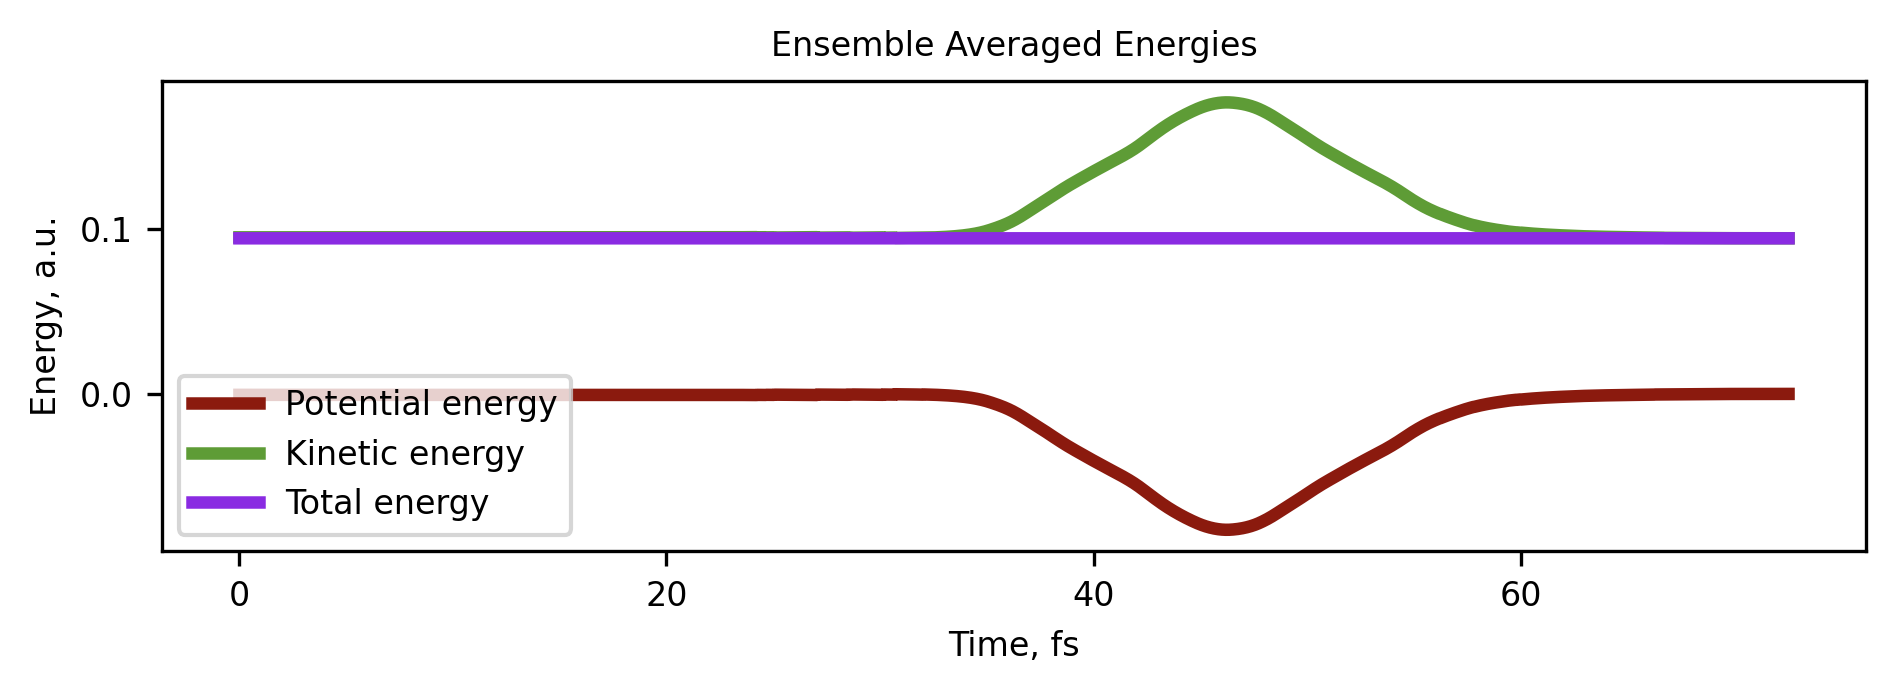

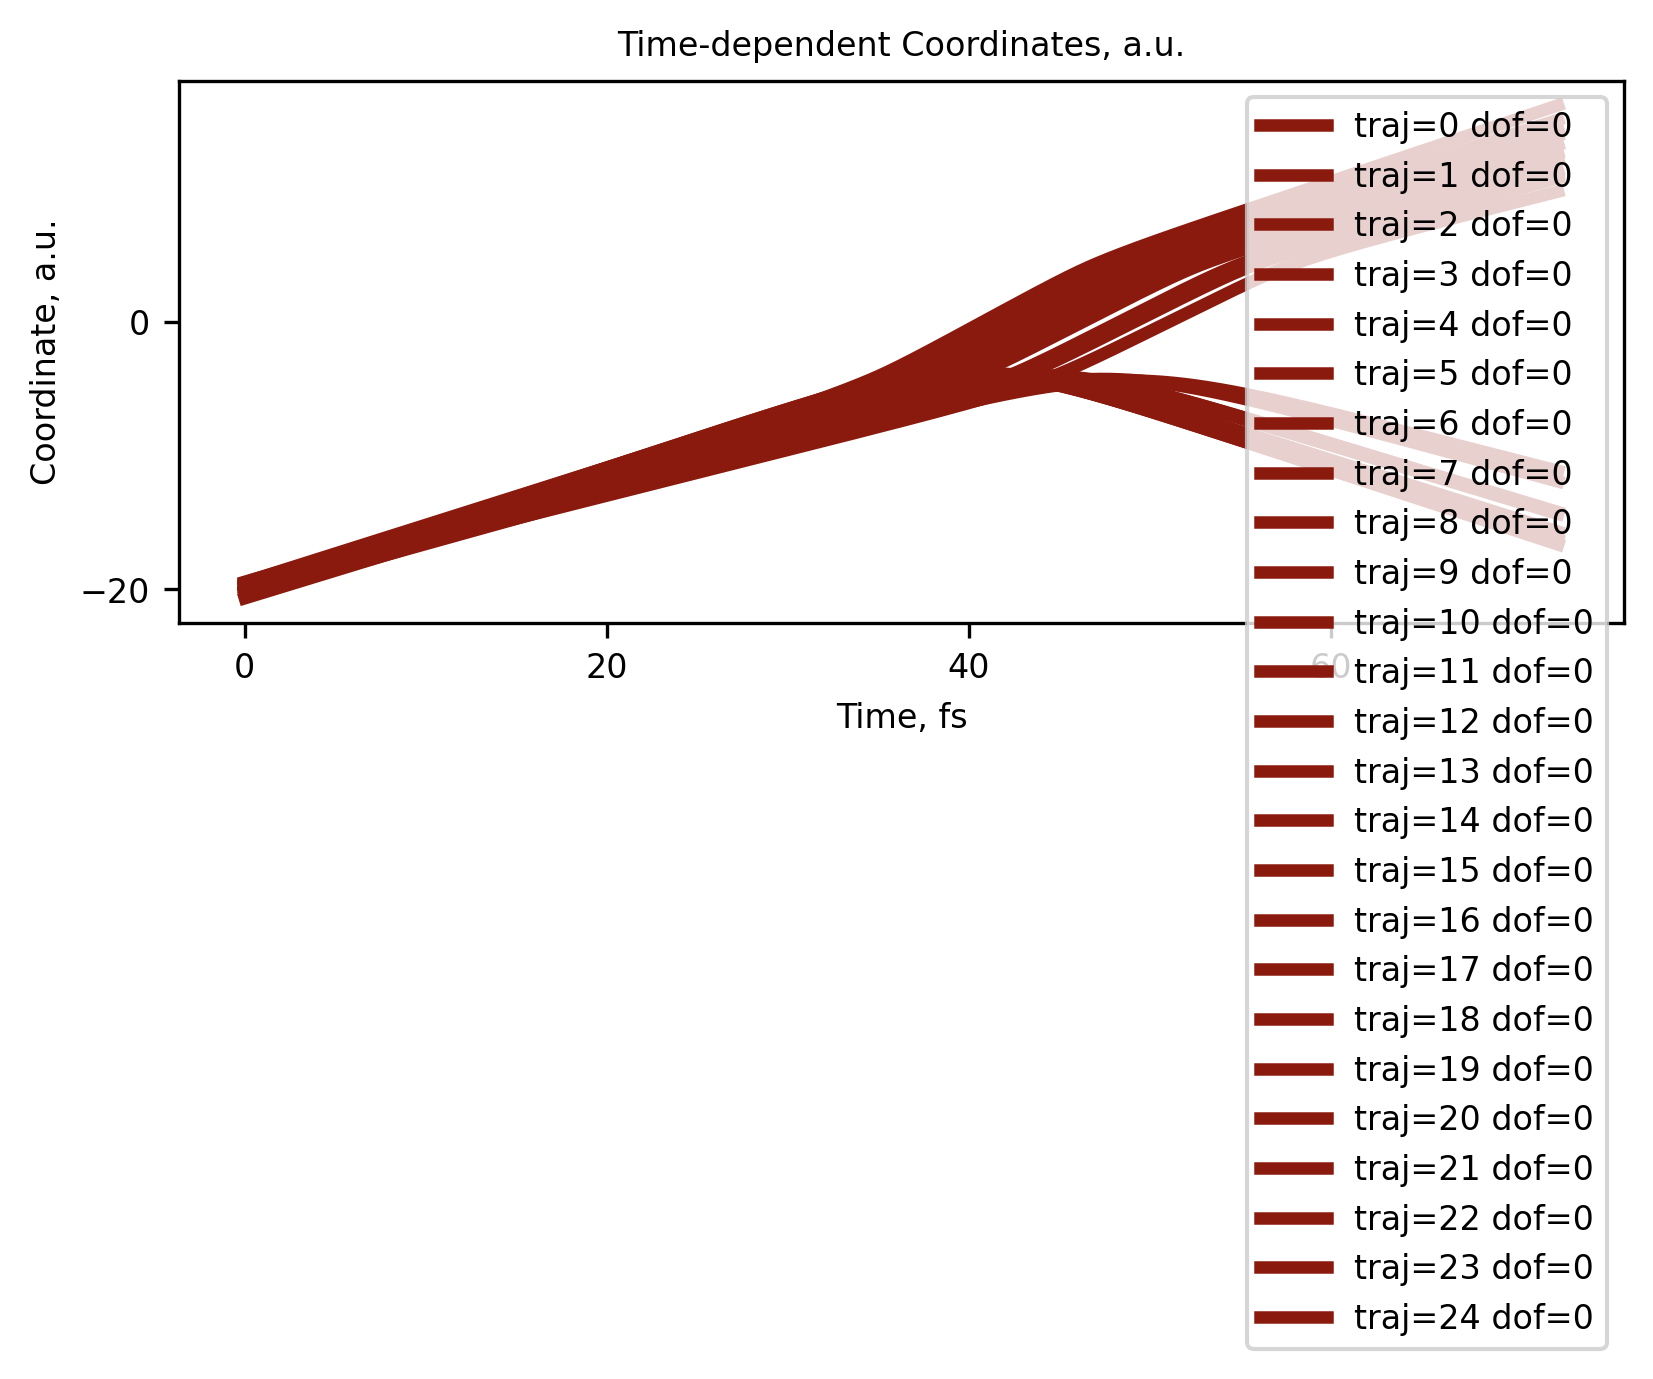

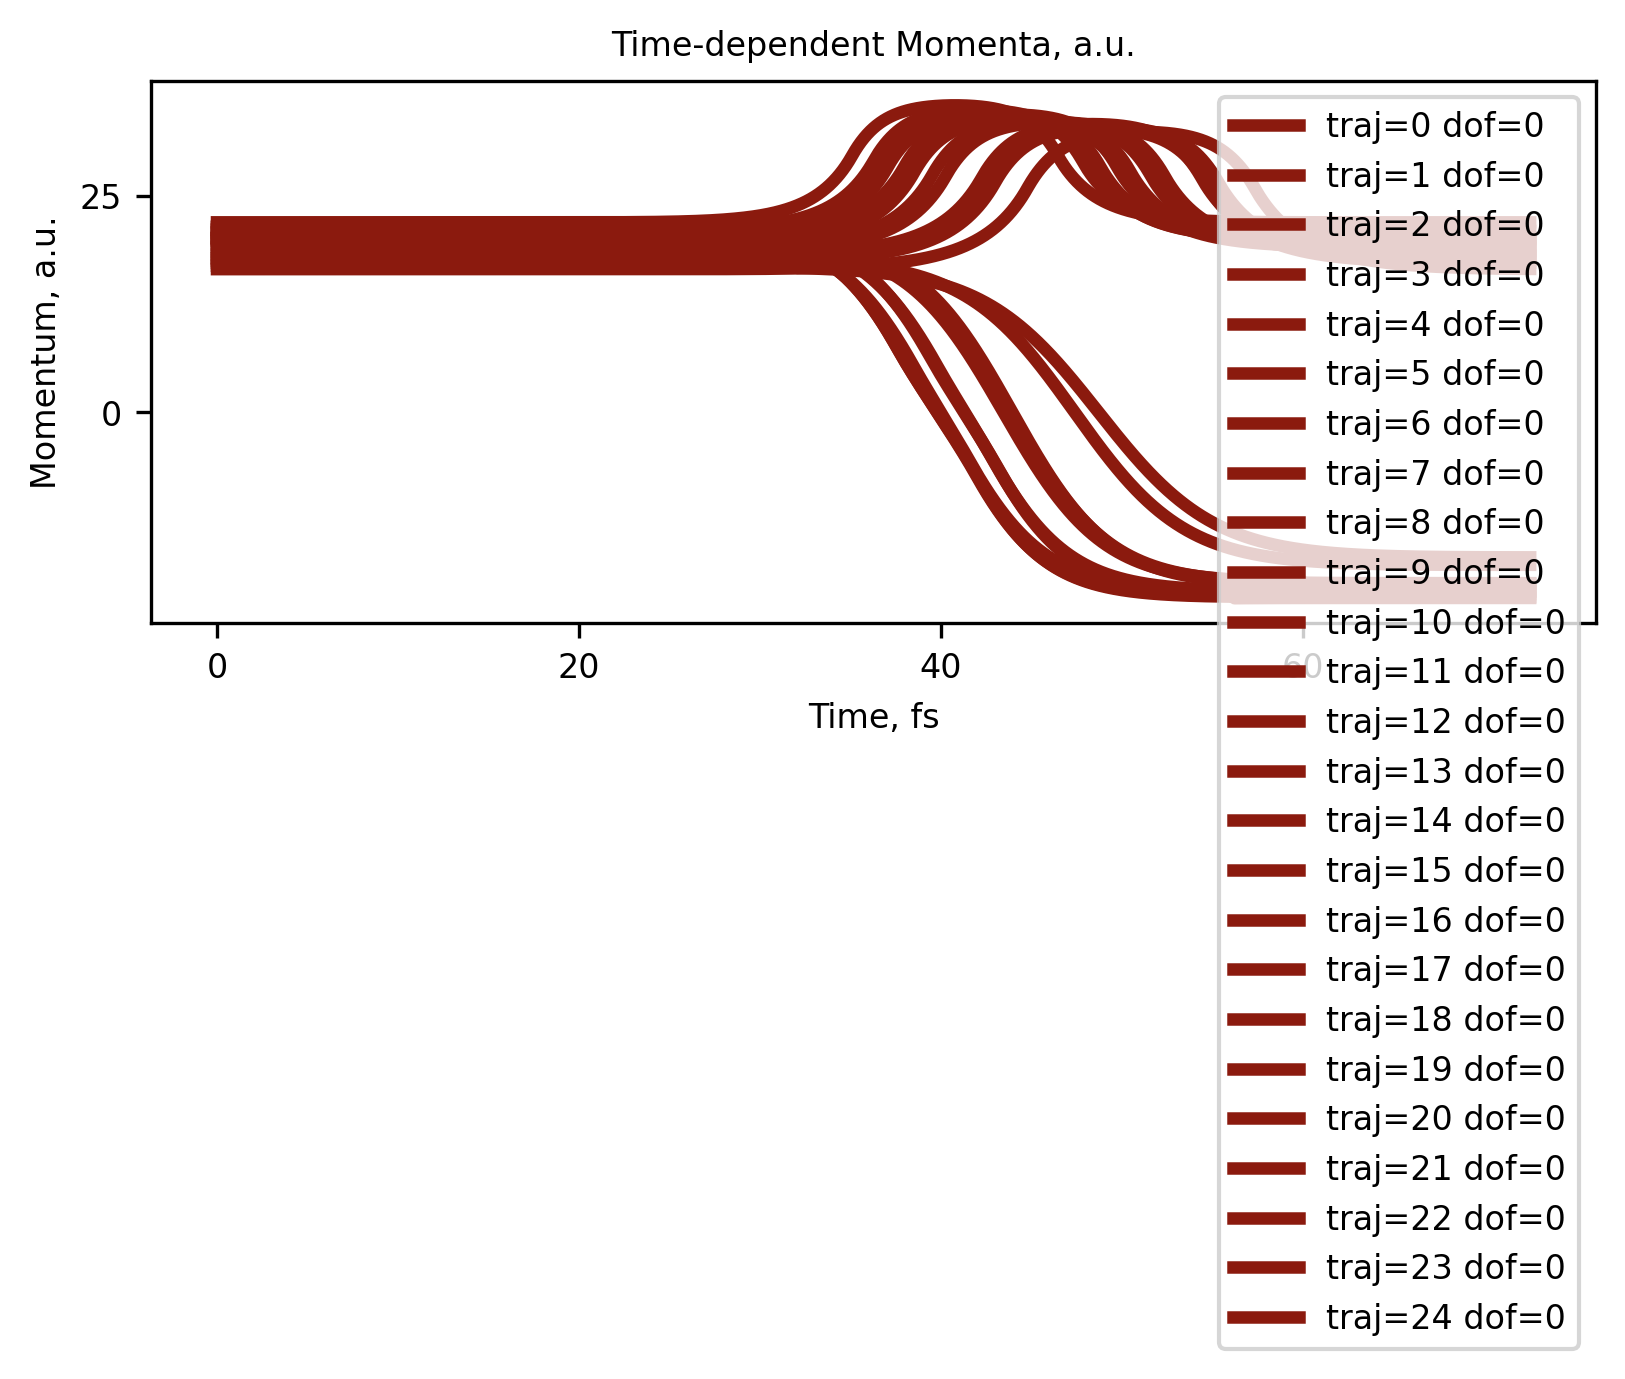

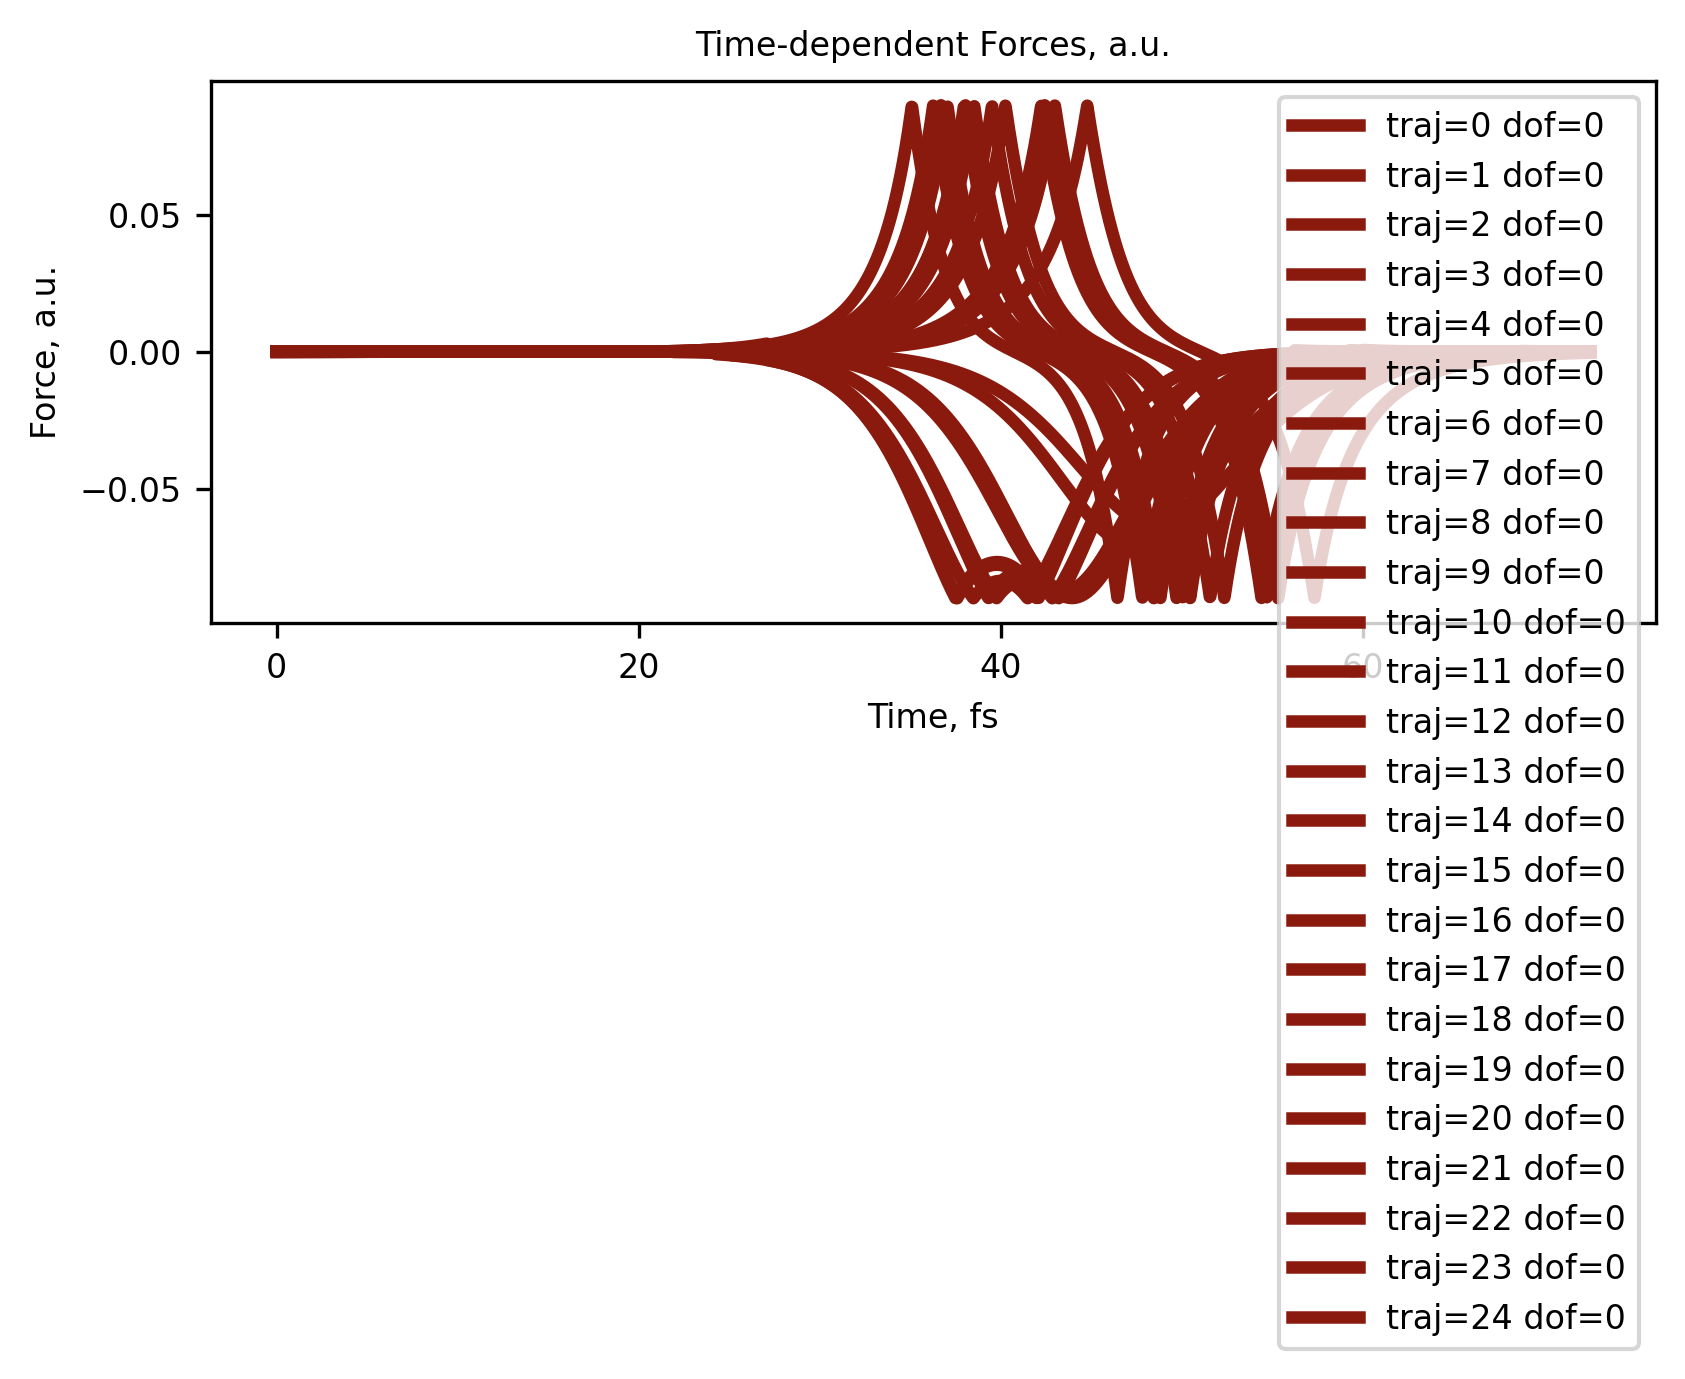

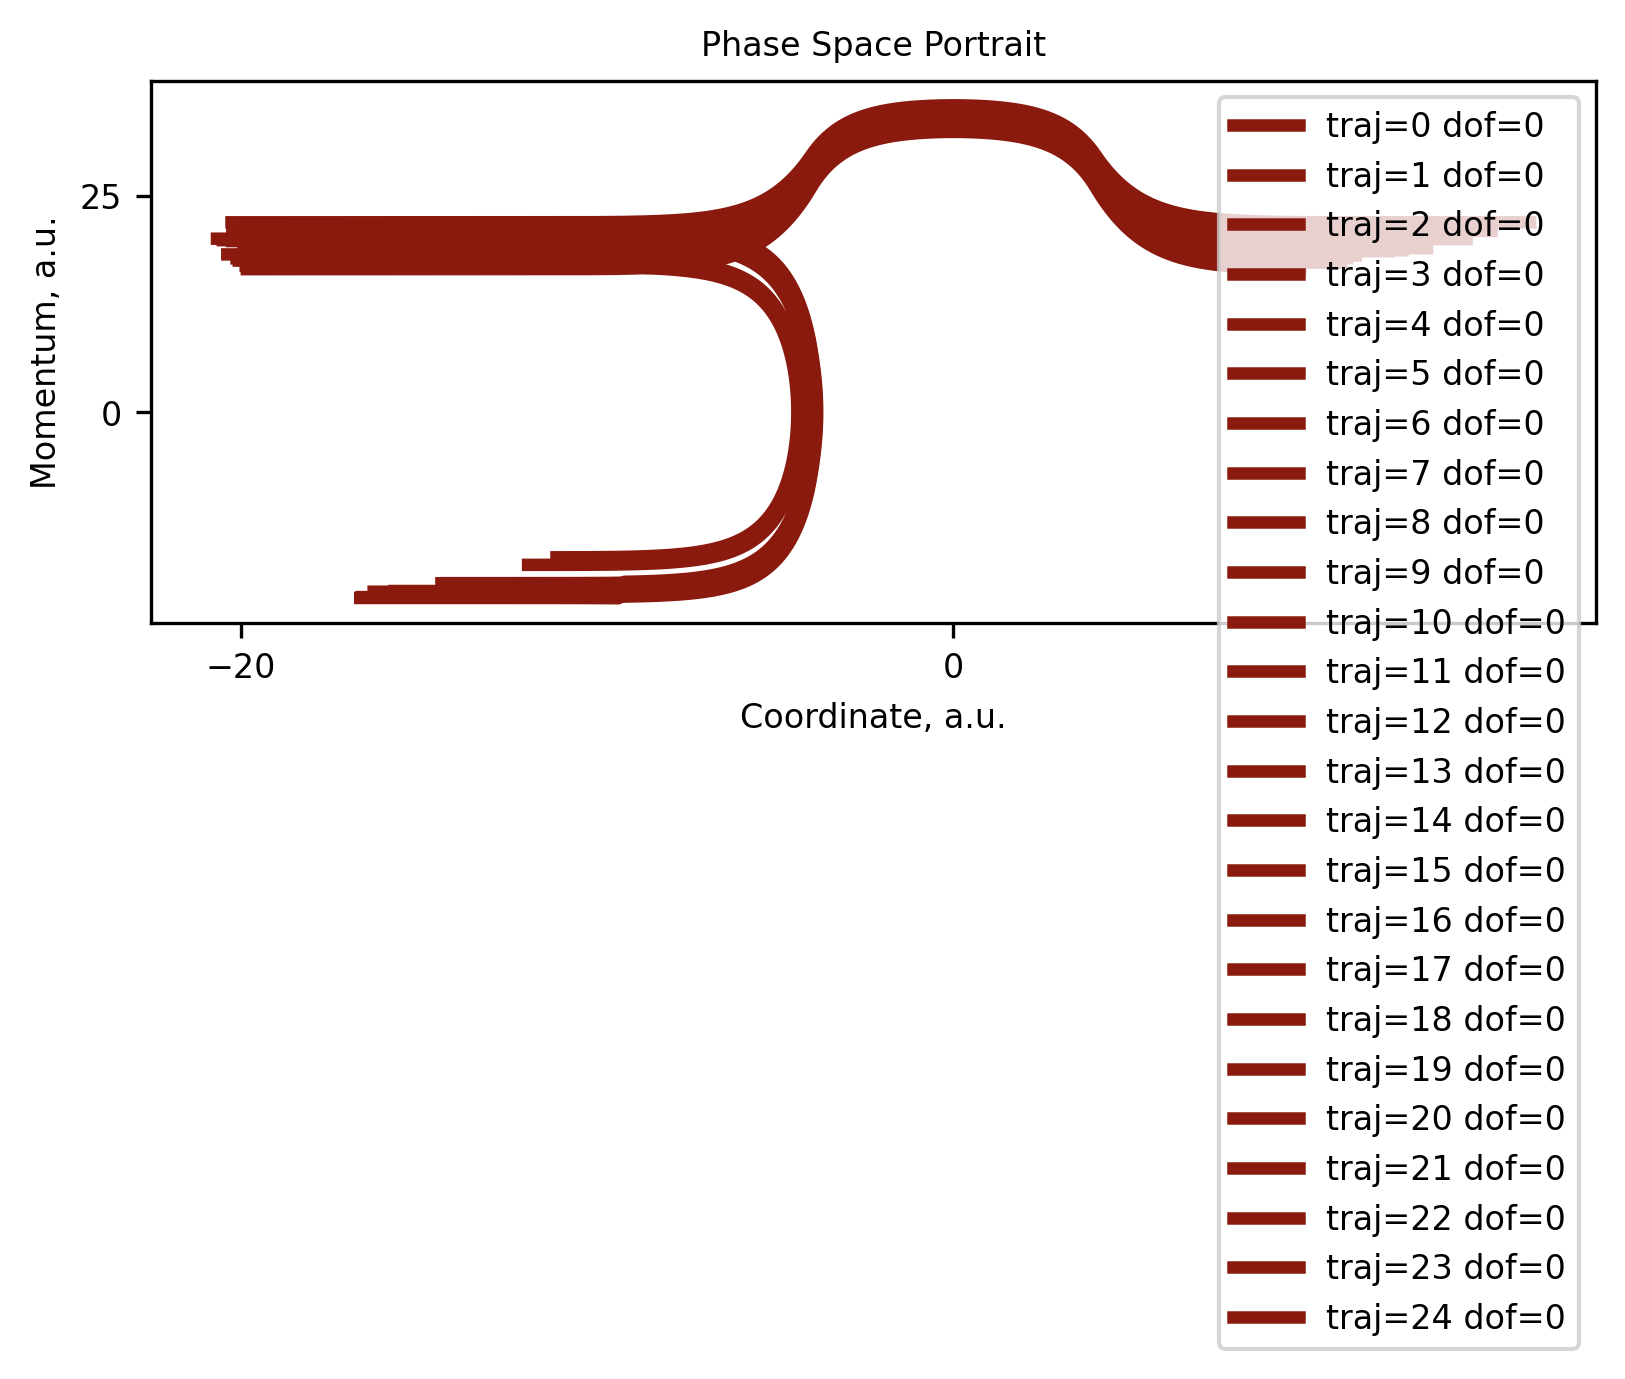

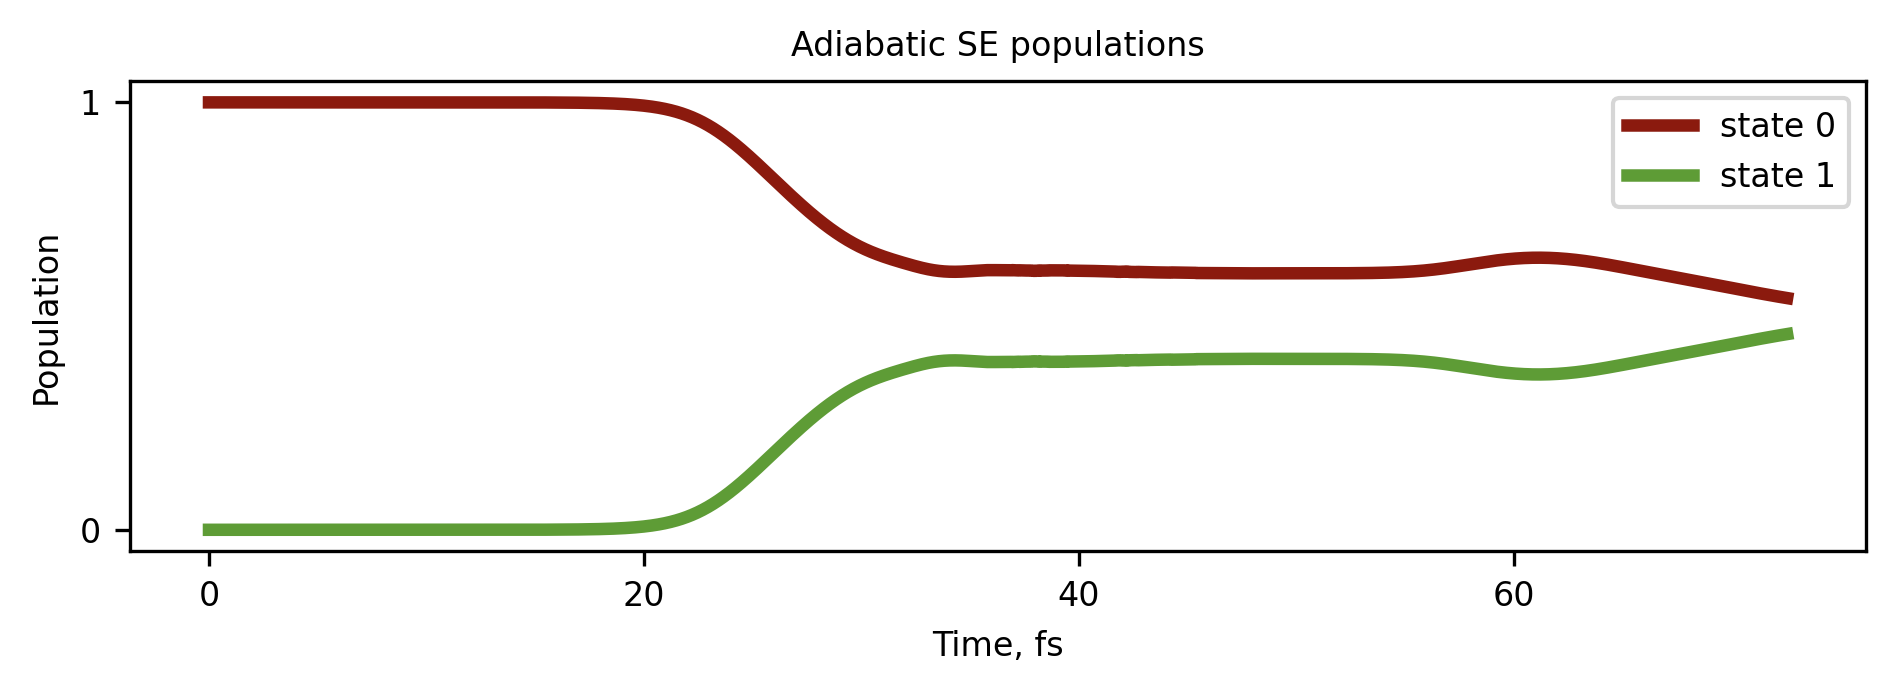

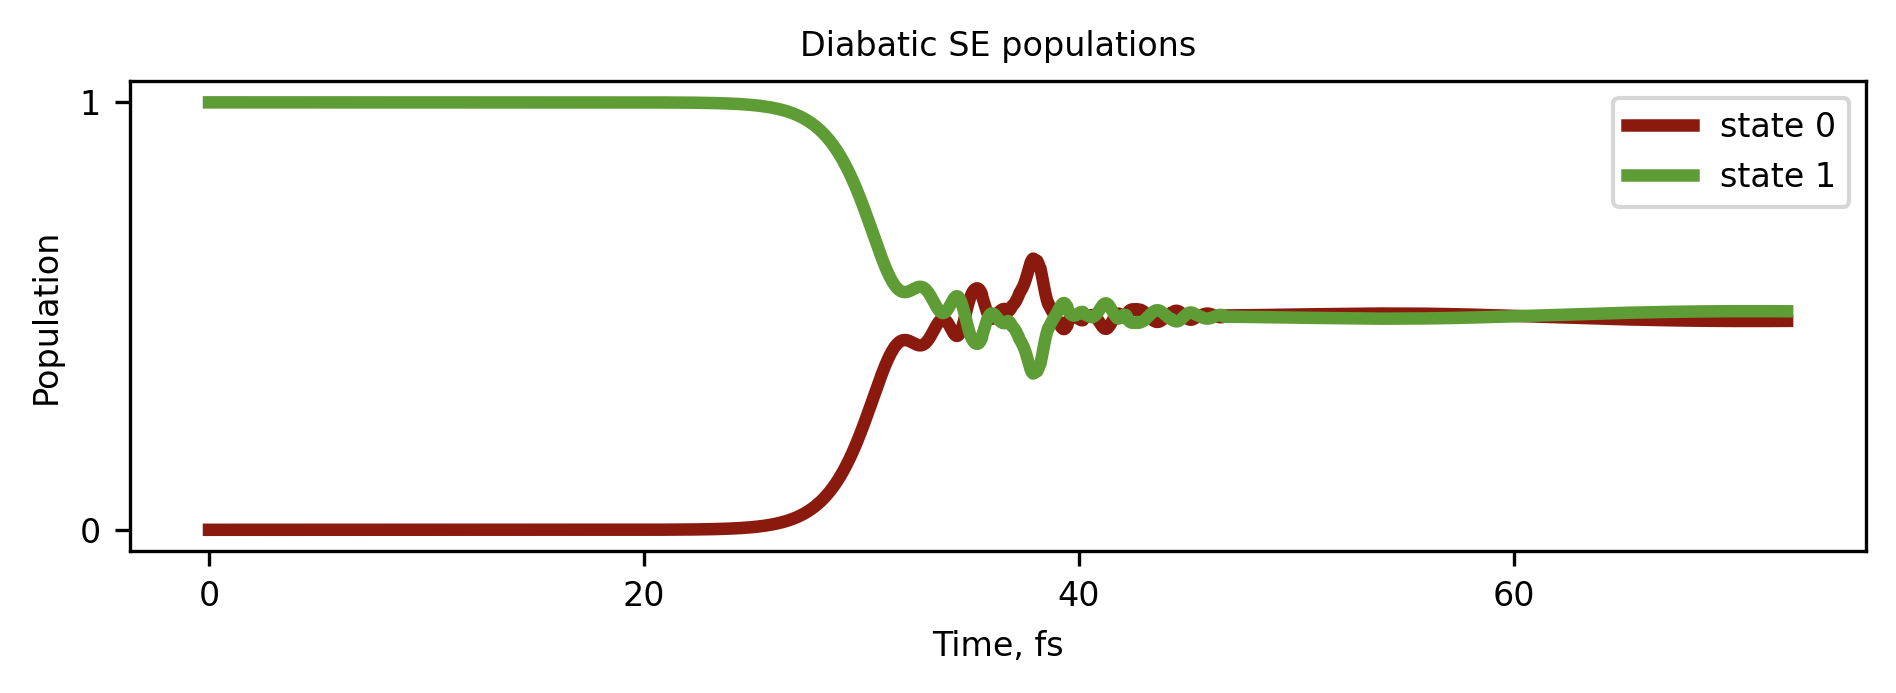

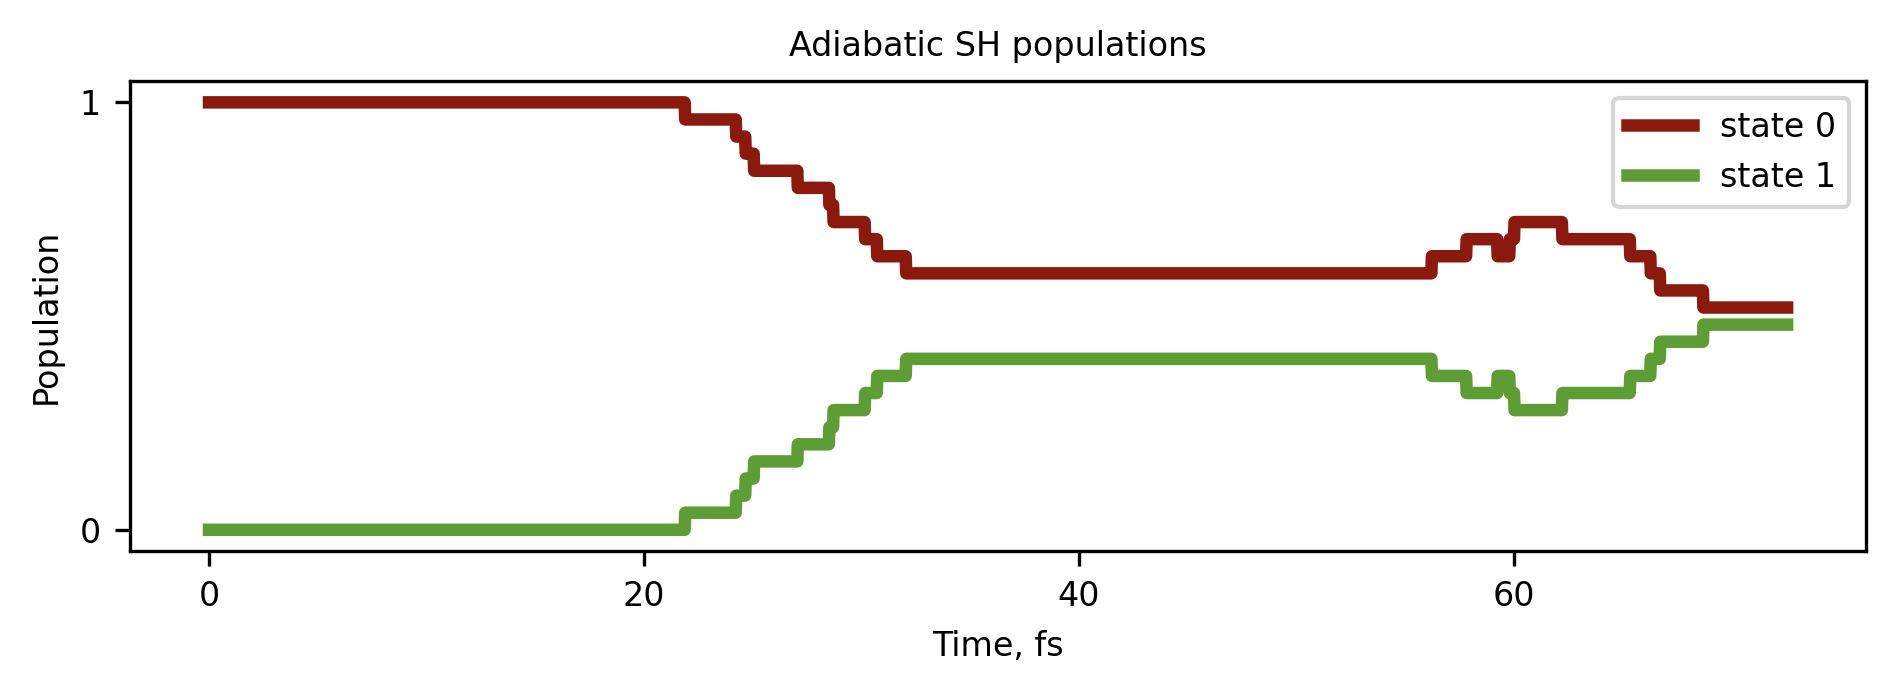

In [27]:
#============ Plotting ==================
pref = F"model{model_indx}-method{method_indx}-icond{icond_indx}"

plot_params = { "prefix":pref, "filename":"mem_data.hdf", "output_level":3,
                "which_trajectories":[0, 1, 2], "which_dofs":[0], "which_adi_states":list(range(NSTATES)), 
                "which_dia_states":list(range(NSTATES)), 
                "frameon":True, "linewidth":3, "dpi":300,
                "axes_label_fontsize":(8,8), "legend_fontsize":8, "axes_fontsize":(8,8), "title_fontsize":8,
                "what_to_plot":["coordinates", "momenta",  "forces", "energies", "phase_space", "se_pop_adi",
                                "se_pop_dia", "sh_pop_adi" ], 
                "which_energies":["potential", "kinetic", "total"],
                "save_figures":1, "do_show":1
              }

#"what_to_plot":["coordinates", "momenta",  "forces", "energies", "phase_space", "se_pop_adi",
#                                "se_pop_dia", "sh_pop_adi", "traj_resolved_adiabatic_ham", "traj_resolved_diabatic_ham", 
#                                "time_overlaps", "basis_transform"
#                               ], 

tsh_dynamics_plot.plot_dynamics(plot_params)

## 8. Comparison with quantum dynamics
<a name="8"></a>[Back to TOC](#TOC)

In [24]:
# For setting the initial state
state_indx = [i for i in range(len(elec_params["istates"])) if elec_params["istates"][i] > 0.5][0]


def potential(q, params):
    full_id = Py2Cpp_int([0,0]) 
    
    return compute_model(q, params, full_id)

In [29]:
exact_params = { "nsteps":list_nsteps[model_indx], "dt":1.0, "progress_frequency":1.0/2500,
                 "rmin":[-25.0], "rmax":[25.0], "dx":[0.025], "nstates":2,
                  "x0":nucl_params["q"], "p0":nucl_params["p"], "istate":[1,state_indx], "masses":[2000.0], "k":[0.001],
                  "integrator":"SOFT",
                  "mem_output_level":0, "txt_output_level":0, "txt2_output_level":0, "hdf5_output_level":2, 
                  "properties_to_save":[ "timestep", "time", "Epot_dia", "Ekin_dia", "Etot_dia",
                                         "Epot_adi", "Ekin_adi", "Etot_adi", "norm_dia", "norm_adi",
                                         "pop_dia", "pop_adi", "q_dia", "q_adi", "p_dia", "p_adi" ],
                  "prefix":F"exact-method{method_indx}-icond{icond_indx}", "prefix2":F"exact-method{method_indx}-icond{icond_indx}",
                  "use_compression":0, "compression_level":[0, 0, 0]
               }

wfc = dvr.init_wfc(exact_params, potential, model_params)
savers = dvr_save.init_tsh_savers(exact_params, model_params, exact_params["nsteps"], wfc)
dvr.run_dynamics(wfc, exact_params, model_params, savers)

Grids are initialized
Added a Gaussian to the grid
Dimension 0 has 2048 grid points
Grid size is calculated
Minimal wavevector along dimension 0 is -20
Lower wavevectors are computed 
nstates = 2
ndof = 1
Dimension 0 has 2048 grid points
Norm (dia) =  1.0000000000000002
Norm (adi) =  1.0
Ekin (dia) =  0.1001767766960692
Ekin (adi) =  0.10017677669529566
Epot (dia) =  -0.0006000000045838868
Epot (adi) =  -0.0006000000045838868
HDF5 saver is initialized...
the datasets that can be saved are: ['timestep', 'time', 'Epot_dia', 'Ekin_dia', 'Etot_dia', 'Epot_adi', 'Ekin_adi', 'Etot_adi', 'norm_dia', 'norm_adi', 'pop_dia', 'pop_adi', 'q_dia', 'q_adi', 'p_dia', 'p_adi']
 step= 0
 step= 1
 step= 2
 step= 3
 step= 4
 step= 5
 step= 6
 step= 7
 step= 8
 step= 9
 step= 10
 step= 11
 step= 12
 step= 13
 step= 14
 step= 15
 step= 16
 step= 17
 step= 18
 step= 19
 step= 20
 step= 21
 step= 22
 step= 23
 step= 24
 step= 25
 step= 26
 step= 27
 step= 28
 step= 29
 step= 30
 step= 31
 step= 32
 step= 33


 step= 597
 step= 598
 step= 599
 step= 600
 step= 601
 step= 602
 step= 603
 step= 604
 step= 605
 step= 606
 step= 607
 step= 608
 step= 609
 step= 610
 step= 611
 step= 612
 step= 613
 step= 614
 step= 615
 step= 616
 step= 617
 step= 618
 step= 619
 step= 620
 step= 621
 step= 622
 step= 623
 step= 624
 step= 625
 step= 626
 step= 627
 step= 628
 step= 629
 step= 630
 step= 631
 step= 632
 step= 633
 step= 634
 step= 635
 step= 636
 step= 637
 step= 638
 step= 639
 step= 640
 step= 641
 step= 642
 step= 643
 step= 644
 step= 645
 step= 646
 step= 647
 step= 648
 step= 649
 step= 650
 step= 651
 step= 652
 step= 653
 step= 654
 step= 655
 step= 656
 step= 657
 step= 658
 step= 659
 step= 660
 step= 661
 step= 662
 step= 663
 step= 664
 step= 665
 step= 666
 step= 667
 step= 668
 step= 669
 step= 670
 step= 671
 step= 672
 step= 673
 step= 674
 step= 675
 step= 676
 step= 677
 step= 678
 step= 679
 step= 680
 step= 681
 step= 682
 step= 683
 step= 684
 step= 685
 step= 686
 step= 687

 step= 1316
 step= 1317
 step= 1318
 step= 1319
 step= 1320
 step= 1321
 step= 1322
 step= 1323
 step= 1324
 step= 1325
 step= 1326
 step= 1327
 step= 1328
 step= 1329
 step= 1330
 step= 1331
 step= 1332
 step= 1333
 step= 1334
 step= 1335
 step= 1336
 step= 1337
 step= 1338
 step= 1339
 step= 1340
 step= 1341
 step= 1342
 step= 1343
 step= 1344
 step= 1345
 step= 1346
 step= 1347
 step= 1348
 step= 1349
 step= 1350
 step= 1351
 step= 1352
 step= 1353
 step= 1354
 step= 1355
 step= 1356
 step= 1357
 step= 1358
 step= 1359
 step= 1360
 step= 1361
 step= 1362
 step= 1363
 step= 1364
 step= 1365
 step= 1366
 step= 1367
 step= 1368
 step= 1369
 step= 1370
 step= 1371
 step= 1372
 step= 1373
 step= 1374
 step= 1375
 step= 1376
 step= 1377
 step= 1378
 step= 1379
 step= 1380
 step= 1381
 step= 1382
 step= 1383
 step= 1384
 step= 1385
 step= 1386
 step= 1387
 step= 1388
 step= 1389
 step= 1390
 step= 1391
 step= 1392
 step= 1393
 step= 1394
 step= 1395
 step= 1396
 step= 1397
 step= 1398
 ste

 step= 2002
 step= 2003
 step= 2004
 step= 2005
 step= 2006
 step= 2007
 step= 2008
 step= 2009
 step= 2010
 step= 2011
 step= 2012
 step= 2013
 step= 2014
 step= 2015
 step= 2016
 step= 2017
 step= 2018
 step= 2019
 step= 2020
 step= 2021
 step= 2022
 step= 2023
 step= 2024
 step= 2025
 step= 2026
 step= 2027
 step= 2028
 step= 2029
 step= 2030
 step= 2031
 step= 2032
 step= 2033
 step= 2034
 step= 2035
 step= 2036
 step= 2037
 step= 2038
 step= 2039
 step= 2040
 step= 2041
 step= 2042
 step= 2043
 step= 2044
 step= 2045
 step= 2046
 step= 2047
 step= 2048
 step= 2049
 step= 2050
 step= 2051
 step= 2052
 step= 2053
 step= 2054
 step= 2055
 step= 2056
 step= 2057
 step= 2058
 step= 2059
 step= 2060
 step= 2061
 step= 2062
 step= 2063
 step= 2064
 step= 2065
 step= 2066
 step= 2067
 step= 2068
 step= 2069
 step= 2070
 step= 2071
 step= 2072
 step= 2073
 step= 2074
 step= 2075
 step= 2076
 step= 2077
 step= 2078
 step= 2079
 step= 2080
 step= 2081
 step= 2082
 step= 2083
 step= 2084
 ste

 step= 2688
 step= 2689
 step= 2690
 step= 2691
 step= 2692
 step= 2693
 step= 2694
 step= 2695
 step= 2696
 step= 2697
 step= 2698
 step= 2699
 step= 2700
 step= 2701
 step= 2702
 step= 2703
 step= 2704
 step= 2705
 step= 2706
 step= 2707
 step= 2708
 step= 2709
 step= 2710
 step= 2711
 step= 2712
 step= 2713
 step= 2714
 step= 2715
 step= 2716
 step= 2717
 step= 2718
 step= 2719
 step= 2720
 step= 2721
 step= 2722
 step= 2723
 step= 2724
 step= 2725
 step= 2726
 step= 2727
 step= 2728
 step= 2729
 step= 2730
 step= 2731
 step= 2732
 step= 2733
 step= 2734
 step= 2735
 step= 2736
 step= 2737
 step= 2738
 step= 2739
 step= 2740
 step= 2741
 step= 2742
 step= 2743
 step= 2744
 step= 2745
 step= 2746
 step= 2747
 step= 2748
 step= 2749
 step= 2750
 step= 2751
 step= 2752
 step= 2753
 step= 2754
 step= 2755
 step= 2756
 step= 2757
 step= 2758
 step= 2759
 step= 2760
 step= 2761
 step= 2762
 step= 2763
 step= 2764
 step= 2765
 step= 2766
 step= 2767
 step= 2768
 step= 2769
 step= 2770
 ste

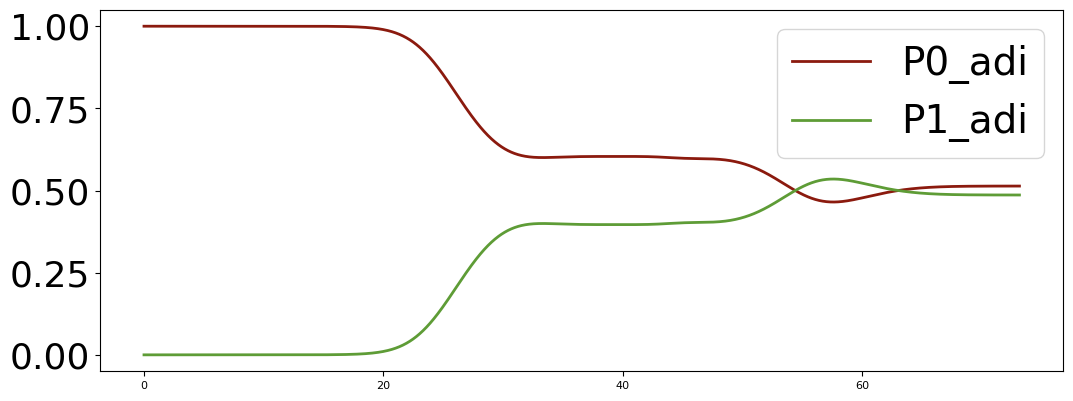

In [30]:
plt.figure(figsize=(2*6.42, 2*2.41))
plt.xticks(fontsize=8)
with h5py.File(F"exact-method{method_indx}-icond{icond_indx}/data.hdf", 'r') as f:        
    plt.plot(f["time/data"][:]/41.0, f["pop_adi/data"][:, 0, 0], label="P0_adi", linewidth=2, color = colors["11"])
    plt.plot(f["time/data"][:]/41.0, f["pop_adi/data"][:, 1, 0], label="P1_adi", linewidth=2, color = colors["21"])
    plt.legend()